In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)
np.set_printoptions(suppress=True)
df = pd.read_csv('data/covid_19_data.csv')

In [2]:
# I referred code regarding data preprocessing from https://www.kaggle.com/chirag9073/coronavirus-covid-19-outbreak-data-analysis

df.drop(['SNo'], axis=1, inplace=True)
df['ObservationDate'] = df['ObservationDate'].apply(pd.to_datetime)

In [3]:
df.head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
5,2020-01-22,Guangdong,Mainland China,1/22/2020 17:00,26.0,0.0,0.0
6,2020-01-22,Guangxi,Mainland China,1/22/2020 17:00,2.0,0.0,0.0
7,2020-01-22,Guizhou,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
8,2020-01-22,Hainan,Mainland China,1/22/2020 17:00,4.0,0.0,0.0
9,2020-01-22,Hebei,Mainland China,1/22/2020 17:00,1.0,0.0,0.0


In [4]:
df.isnull().sum()

ObservationDate      0
Province/State     982
Country/Region       0
Last Update          0
Confirmed            0
Deaths               0
Recovered            0
dtype: int64

In [5]:
df[df['Province/State'].isnull()].head(10)

,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
35,2020-01-22,NaN,Japan,1/22/2020 17:00,2.0,0.0,0.0
36,2020-01-22,NaN,Thailand,1/22/2020 17:00,2.0,0.0,0.0
37,2020-01-22,NaN,South Korea,1/22/2020 17:00,1.0,0.0,0.0
73,2020-01-23,NaN,Japan,1/23/20 17:00,1.0,0.0,0.0
74,2020-01-23,NaN,Thailand,1/23/20 17:00,3.0,0.0,0.0
75,2020-01-23,NaN,South Korea,1/23/20 17:00,1.0,0.0,0.0
76,2020-01-23,NaN,Singapore,1/23/20 17:00,1.0,0.0,0.0
77,2020-01-23,NaN,Philippines,1/23/20 17:00,0.0,0.0,0.0
78,2020-01-23,NaN,Malaysia,1/23/20 17:00,0.0,0.0,0.0
79,2020-01-23,NaN,Vietnam,1/23/20 17:00,2.0,0.0,0.0


In [6]:
# Current situation
grouped_df = df.groupby(['Country/Region', 'Province/State'])['Confirmed', 'Deaths', 'Recovered'].max()
grouped_df.style.background_gradient(cmap='Pastel1_r')

In [7]:
# Top 10 Countries with most no. of reported cases
latest_df = df[df['ObservationDate'] == max(df['ObservationDate'])].reset_index()
grouped_df = latest_df.groupby('Country/Region')['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()

temp = grouped_df[['Country/Region', 'Confirmed']]
temp = temp.sort_values(by='Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.head(10).style.background_gradient(cmap='Pastel1_r')

,Country/Region,Confirmed
0,Mainland China,80026
1,South Korea,4335
2,Italy,2036
3,Iran,1501
4,Others,705
5,Japan,274
6,France,191
7,Germany,159
8,Spain,120
9,Singapore,108


In [8]:
# Countries with all the cases recovered
temp = grouped_df[grouped_df['Confirmed']==grouped_df['Recovered']]
temp = temp[['Country/Region', 'Confirmed', 'Recovered']]
temp = temp.sort_values('Confirmed', ascending=False)
temp = temp.reset_index(drop=True)
temp.style.background_gradient(cmap='Greens')

,Country/Region,Confirmed,Recovered
0,Vietnam,16,16
1,Cambodia,1,1
2,Nepal,1,1
3,Sri Lanka,1,1


In [9]:
# Most recent stats
world_daily_df = df.groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
world_daily_df = world_daily_df.reset_index()
world_daily_df = world_daily_df.sort_values('ObservationDate', ascending=False)
world_daily_df.head(1).style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602


In [10]:
world_daily_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,90309,3085,45602
39,2020-03-01 00:00:00,88371,2996,42716
38,2020-02-29 00:00:00,86013,2941,39782
37,2020-02-28 00:00:00,84124,2872,36711
36,2020-02-27 00:00:00,82756,2814,33277
35,2020-02-26 00:00:00,81397,2770,30384
34,2020-02-25 00:00:00,80415,2708,27905
33,2020-02-24 00:00:00,79570,2629,25227
32,2020-02-23 00:00:00,78985,2469,23394
31,2020-02-22 00:00:00,78599,2458,22886


In [11]:
world_daily_df.isnull().sum()

ObservationDate    0
Confirmed          0
Deaths             0
Recovered          0
dtype: int64

In [12]:
# from https://tykimos.github.io/2017/04/09/RNN_Layer_Talk/
import keras

class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

Using TensorFlow backend.


In [13]:

import datetime
import os
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint

WINDOW_SIZE = 8

class PandemicRegressor():
    def __init__(self, window_size, batch_size, n_feature, model_name, hidden_state=False, stateful=False, loss_hist=None):
        self.window_size = window_size
        self.batch_size = batch_size
        self.n_feature = n_feature
        save_dir = os.path.join(os.path.join(os.getcwd(), 'model'), 
                                datetime.datetime.now().strftime('%Y-%m-%d;%H.%M.%S'))
        os.mkdir(save_dir)
        self.model_path = os.path.join(save_dir, model_name + '.best.hdf5')
        print(self.model_path)
        self.hidden_state = hidden_state
        self.stateful = stateful
        if stateful:
            self.callbacks = [loss_hist]
        else:
            self.callbacks = [EarlyStopping(monitor='val_mape', patience=100), 
                 ModelCheckpoint(self.model_path, monitor='val_mape', verbose=0, save_best_only=True, mode='min')]
        self.reg = self.build_model(hidden_state, stateful)
        
    def build_model(self, hidden_state, stateful):
        model = Sequential()
        if hidden_state:
            if stateful:
                model.add(LSTM(1024, batch_input_shape=(self.batch_size, self.window_size, self.n_feature), dropout=0.5, stateful=True))
            else:
                model.add(LSTM(1024, input_shape=(self.window_size, self.n_feature), dropout=0.5))
        else:
             model.add(Dense(1024, input_dim=(self.window_size * self.n_feature),activation='relu'))
        
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(self.n_feature, activation='linear'))

        model.compile(loss='mean_squared_error', 
                      optimizer='adam',
                      metrics=['mae', 'mape'])
        return model
    
    def reset_states(self):
        # reset hiden states
        self.reg.reset_states()
    
    def fit(self, X_train, y_train, validation_data, epochs=500, verbose=1, shuffle=False):
        hist = self.reg.fit(X_train, 
                            y_train, 
                            epochs=epochs, 
                            batch_size=self.batch_size,
                            validation_data=validation_data,
                            callbacks=self.callbacks,
                            verbose=verbose,
                            shuffle=shuffle)
        return hist
    
    def predict_n_days(self, n, seq_in, scaler):
        _mean = scaler['mean']
        _std = scaler['std']
        
        if self.hidden_state:
            seq_in = list(seq_in)
            seq_out = []
            for i in range(n):
                temp = np.array(seq_in)
                temp = np.reshape(temp, (1, self.window_size, self.n_feature)) # n_sample, seq_len, n_feature
                y_hat = self.reg.predict(temp)
                seq_out.append(y_hat[0])
                y_hat = (y_hat - _mean) / _std
                seq_in.append(y_hat[0])
                seq_in.pop(0)
        else:
            seq_in = list(seq_in)
            seq_out = []
            for i in range(n):
                temp = np.array(seq_in)
                temp = np.reshape(temp, (1, self.window_size * self.n_feature)) # n_sample, seq_len, n_feature
                y_hat = self.reg.predict(temp)
                seq_out.append(y_hat[0])
                y_hat = (y_hat - _mean) / _std
                seq_in.append(y_hat[0])
                seq_in.pop(0)
        _df = pd.DataFrame(seq_out)
        _df.columns = ['Confirmed', 'Deaths', 'Recovered']
        return _df
    
    def predict(self, X):
        return self.reg.predict(X)
    
    def evaluate(self, X_test, y_test):
        loss_and_metrics = self.reg.evaluate(X_test, 
                                             y_test, 
                                             batch_size=self.batch_size)
        return loss_and_metrics
    
    def load_best_weights(self):
        self.reg.load_weights(self.model_path)
    
    def save(self):
        self.reg.save(self.model_path)


In [14]:
%matplotlib inline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def show_train_hist(hist):
    plt.plot(hist.history['loss'], 'b-', label='train_loss')
    plt.plot(hist.history['val_loss'], 'r', label='val_loss')
    plt.title("loss history")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Normalize
_mean = np.mean(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)

print(_mean)
print(_std)

[46077.41463415  1313.85365854 11462.34146341]
[31966.13245523  1056.92768198 13683.82920771]


In [15]:
def seq2dataset(sr, window_size):
        seq_data = []
        for i in range(len(sr) - window_size):
            subset = list(sr[i:(i+window_size+1)])
            subset.reverse()
            seq_data.append(subset)
        seq_data.reverse()
        seq_data = np.array(seq_data)
        return seq_data[:,0:window_size,:], seq_data[:,window_size,:]

In [16]:
X, y = seq2dataset(world_daily_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X

array([[[  555.,    17.,    28.],
        [  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.]],

       [[  653.,    18.,    30.],
        [  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.]],

       [[  941.,    26.,    36.],
        [ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        [ 8235.,   171.,   143.],
        [ 9925.,   213.,   222.]],

       [[ 1438.,    42.,    39.],
        [ 2118.,    56.,    52.],
        [ 2927.,    82.,    61.],
        [ 5578.,   131.,   107.],
        [ 6165.,   133.,   126.],
        

In [17]:
y

array([[ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80415.,  2708., 27905.],
       [81397.,  2770., 30384.],
       [82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86

In [18]:
X = (X - _mean) / _std

In [19]:
X

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804],
        [-1.18382837, -1.08129788, -0.8272057 ]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.2669

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

In [21]:
X_train

array([[[-1.42408265, -1.22700321, -0.83560978],
        [-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804]],

       [[-1.42101691, -1.22605707, -0.83546362],
        [-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.26694759, -1.11914342, -0.82983654],
        [-1.24858441, -1.11725114, -0.82844804],
        [-1.18382837, -1.08129788, -0.8272057 ]],

       [[-1.41200737, -1.21848796, -0.83502514],
        [-1.39645967, -1.20334975, -0.83480591],
        [-1.37518715, -1.19010381, -0.83385588],
        [-1.34987912, -1.16550421, -0.83319817],
        [-1.2669

In [22]:
X_test

array([[[0.92484086, 0.76461839, 0.34044992],
        [0.94229683, 0.8828857 , 0.49070026],
        [0.96244315, 0.88667026, 0.54280556],
        [1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512]],

       [[0.94229683, 0.8828857 , 0.49070026],
        [0.96244315, 0.88667026, 0.54280556],
        [1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.37771615, 1.38277512],
        [1.14742018, 1.41934625, 1.59419255]],

       [[0.96244315, 0.88667026, 0.54280556],
        [1.01737629, 1.08252093, 0.83482908],
        [1.02945157, 1.09292846, 0.87195319],
        [1.04775219, 1.24431062, 1.00590692],
        [1.07418642, 1.31905557, 1.20161238],
        [1.10490643, 1.3777161

In [23]:
y_train

array([[ 8235.,   171.,   143.],
       [ 9925.,   213.,   222.],
       [12038.,   259.,   284.],
       [16787.,   362.,   472.],
       [19881.,   426.,   623.],
       [23892.,   492.,   852.],
       [27636.,   564.,  1124.],
       [30818.,   634.,  1487.],
       [34392.,   719.,  2011.],
       [37121.,   806.,  2616.],
       [40151.,   906.,  3244.],
       [42763.,  1013.,  3946.],
       [44803.,  1113.,  4683.],
       [45222.,  1118.,  5150.],
       [60370.,  1371.,  6295.],
       [66887.,  1523.,  8058.],
       [69032.,  1666.,  9395.],
       [71226.,  1770., 10865.],
       [73260.,  1868., 12583.],
       [75138.,  2007., 14352.],
       [75641.,  2122., 16121.],
       [76199.,  2247., 18177.],
       [76843.,  2251., 18890.],
       [78599.,  2458., 22886.],
       [78985.,  2469., 23394.],
       [79570.,  2629., 25227.],
       [80415.,  2708., 27905.],
       [81397.,  2770., 30384.]])

In [24]:
y_test

array([[82756.,  2814., 33277.],
       [84124.,  2872., 36711.],
       [86013.,  2941., 39782.],
       [88371.,  2996., 42716.],
       [90309.,  3085., 45602.]])

C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;03.14.22\world_pdm_reg.best.hdf5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 28 samples, validate on 5 samples
Epoch 1/3000
28/28 [==============================] - 1s 38ms/step - loss: 1151945270.8571 - mae: 20800.7773 - mape: 100.0007 - val_loss: 3018144768.0000 - val_mae: 42957.1602 - val_mape: 99.9981
Epoch 2/3000
28/28 [==============================] - 0s 3ms/step - loss: 1151642985.1429 - mae: 20797.5801 - mape: 99.9685 - val_loss: 3016610560.0000 - val_mae: 42946.9336 - val_mape: 99.9631
Epoch 3/3000
28/28 [==============================] - 0s 4ms/step - loss: 1142029465.1429 - mae: 20692.9180 - mape: 98.2150 - val_loss: 3011713024.0000 - val_mae: 42912.8789 - val_mape: 99.8152
Epoch 4/3000
28/28 [==============================] - 0s 4ms/step - loss: 1096647476.5714 - mae: 20206.0762 - mape: 90.0492 - val_loss: 2999932672.0000 - val_mae: 42827.2695 - val_mape: 9

Epoch 82/3000
28/28 [==============================] - 0s 3ms/step - loss: 166251388.5714 - mae: 8348.5537 - mape: 396.1185 - val_loss: 148318336.0000 - val_mae: 8413.4746 - val_mape: 26.0397
Epoch 83/3000
28/28 [==============================] - 0s 3ms/step - loss: 151653065.1429 - mae: 7493.3047 - mape: 334.6559 - val_loss: 158440464.0000 - val_mae: 9242.8105 - val_mape: 30.1366
Epoch 84/3000
28/28 [==============================] - 0s 3ms/step - loss: 116552194.2857 - mae: 7364.5142 - mape: 305.7850 - val_loss: 176684336.0000 - val_mae: 10315.4443 - val_mape: 33.5876
Epoch 85/3000
28/28 [==============================] - 0s 3ms/step - loss: 157124049.1429 - mae: 8714.4434 - mape: 329.4027 - val_loss: 163124272.0000 - val_mae: 9659.2480 - val_mape: 29.5235
Epoch 86/3000
28/28 [==============================] - 0s 3ms/step - loss: 111437446.8571 - mae: 6640.3198 - mape: 360.5368 - val_loss: 159971552.0000 - val_mae: 9361.9277 - val_mape: 24.4842
Epoch 87/3000
28/28 [==================

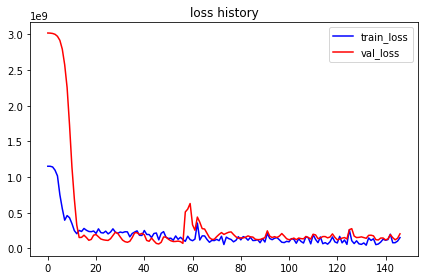

5/5 [==============================] - 0s 1ms/step


In [25]:
"""
Predict the global spread of coronavirus with LSTM modle
"""
pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=True, batch_size=8, n_feature=3, model_name='world_lstm_pdm_reg', stateful=False)

hist = pdm_reg.fit(X_train=X_train, 
                   y_train=y_train, 
                   validation_data=(X_test, y_test),
                   verbose=1,
                   epochs=3000)
show_train_hist(hist)

pdm_reg.load_best_weights()
loss_and_metrics = pdm_reg.evaluate(X_test=X_test, y_test=y_test)

In [26]:
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = pdm_reg.predict(X_test)
y_dict = {'Confirmed': [x[0] for x in y_hat],
          'Deaths':[x[1] for x in y_hat],
          'Recovered':[x[2] for x in y_hat]}
y_df = pd.DataFrame(y_dict)
y_df

MAE: 5354.150390625, MAPE: 12.729644775390625
===================================================== Prediction of X_test =====================================================


,Confirmed,Deaths,Recovered
0,89653.710938,3018.523438,27255.365234
1,89686.648438,3019.634277,27265.384766
2,89719.773438,3020.749756,27275.455078
3,89758.562500,3022.057129,27287.248047
4,89781.804688,3022.839355,27294.310547


In [27]:
n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = pdm_reg.predict_n_days(n, X_test[-1], {'mean': _mean, 'std': _std})
prediction


===================================================== Prediction of 7 days =====================================================


,Confirmed,Deaths,Recovered
0,89781.804688,3022.840576,27294.314453
1,89706.320312,3020.296387,27271.353516
2,89710.773438,3020.447021,27272.716797
3,89700.703125,3020.107422,27269.646484
4,89694.765625,3019.906982,27267.839844
5,89682.843750,3019.505371,27264.216797
6,89676.921875,3019.303467,27262.408203


In [28]:
print(df['Country/Region'].unique())
nation_name = 'South Korea'

['Mainland China' 'Hong Kong' 'Macau' 'Taiwan' 'US' 'Japan' 'Thailand'
 'South Korea' 'Singapore' 'Philippines' 'Malaysia' 'Vietnam' 'Australia'
 'Mexico' 'Brazil' 'Colombia' 'France' 'Nepal' 'Canada' 'Cambodia'
 'Sri Lanka' 'Ivory Coast' 'Germany' 'Finland' 'United Arab Emirates'
 'India' 'Italy' 'UK' 'Russia' 'Sweden' 'Spain' 'Belgium' 'Others' 'Egypt'
 'Iran' 'Israel' 'Lebanon' 'Iraq' 'Oman' 'Afghanistan' 'Bahrain' 'Kuwait'
 'Austria' 'Algeria' 'Croatia' 'Switzerland' 'Pakistan' 'Georgia' 'Greece'
 'North Macedonia' 'Norway' 'Romania' 'Denmark' 'Estonia' 'Netherlands'
 'San Marino' ' Azerbaijan' 'Belarus' 'Iceland' 'Lithuania' 'New Zealand'
 'Nigeria' 'North Ireland' 'Ireland' 'Luxembourg' 'Monaco' 'Qatar'
 'Ecuador' 'Azerbaijan' 'Czech Republic' 'Armenia' 'Dominican Republic'
 'Indonesia' 'Portugal' 'Andorra' 'Latvia' 'Morocco' 'Saudi Arabia'
 'Senegal']


In [29]:
korea_df = df[df['Country/Region'] == nation_name].groupby('ObservationDate')['Confirmed', 'Deaths', 'Recovered'].sum()
korea_df = korea_df.reset_index()
korea_df = korea_df.sort_values('ObservationDate', ascending=False)
korea_df.style.background_gradient(cmap='Pastel1')

,ObservationDate,Confirmed,Deaths,Recovered
40,2020-03-02 00:00:00,4335,28,30
39,2020-03-01 00:00:00,3736,17,30
38,2020-02-29 00:00:00,3150,16,27
37,2020-02-28 00:00:00,2337,13,22
36,2020-02-27 00:00:00,1766,13,22
35,2020-02-26 00:00:00,1261,12,22
34,2020-02-25 00:00:00,977,10,22
33,2020-02-24 00:00:00,833,8,18
32,2020-02-23 00:00:00,602,6,18
31,2020-02-22 00:00:00,433,2,16


In [30]:
# for nation_name in df['Country/Region'].unique():
print(f'[{nation_name} spread of coronavirus19]')
_mean = np.mean(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
_std = np.std(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, axis=0)
    
X, y = seq2dataset(korea_df[['Confirmed', 'Deaths', 'Recovered']].values, WINDOW_SIZE)
X = (X - _mean) / _std
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

[South Korea spread of coronavirus19]


C:\Users\codez\PycharmProjects\CoronavirusDisease2019\model\2020-03-05;03.14.44\korea_pdm_reg.best.hdf5
Train on 28 samples, validate on 5 samples
Epoch 1/3000
28/28 [==============================] - 1s 34ms/step - loss: 45853.4814 - mae: 61.1300 - mape: 13238781.0000 - val_loss: 3414017.2500 - val_mae: 1035.5715 - val_mape: 99.6856
Epoch 2/3000
28/28 [==============================] - 0s 4ms/step - loss: 43627.0941 - mae: 56.7758 - mape: 333223136.0000 - val_loss: 3399573.5000 - val_mae: 1032.3971 - val_mape: 96.8689
Epoch 3/3000
28/28 [==============================] - 0s 4ms/step - loss: 43577.4139 - mae: 82.5476 - mape: 4261449216.0000 - val_loss: 3366169.5000 - val_mae: 1024.4352 - val_mape: 92.3436
Epoch 4/3000
28/28 [==============================] - 0s 4ms/step - loss: 38134.0310 - mae: 64.5480 - mape: 2339190528.0000 - val_loss: 3208380.0000 - val_mae: 991.8255 - val_mape: 81.0156
Epoch 5/3000
28/28 [==============================] - 0s 4ms/step - loss: 34249.2059 - mae: 89.1

28/28 [==============================] - 0s 3ms/step - loss: 20608.8879 - mae: 58.7244 - mape: 1425627264.0000 - val_loss: 1256630.5000 - val_mae: 575.5336 - val_mape: 29.0386
Epoch 87/3000
28/28 [==============================] - 0s 3ms/step - loss: 9489.9491 - mae: 39.9662 - mape: 1160587648.0000 - val_loss: 1481688.0000 - val_mae: 643.0228 - val_mape: 56.9999
Epoch 88/3000
28/28 [==============================] - 0s 3ms/step - loss: 27283.7051 - mae: 73.0484 - mape: 2161238784.0000 - val_loss: 1960941.2500 - val_mae: 767.8099 - val_mape: 102.8422
Epoch 89/3000
28/28 [==============================] - 0s 3ms/step - loss: 21037.4005 - mae: 58.0964 - mape: 1823550208.0000 - val_loss: 2152229.2500 - val_mae: 811.3444 - val_mape: 113.7184
Epoch 90/3000
28/28 [==============================] - 0s 3ms/step - loss: 20778.3563 - mae: 66.1092 - mape: 1697467392.0000 - val_loss: 2143902.0000 - val_mae: 807.7575 - val_mape: 105.2153
Epoch 91/3000
28/28 [==============================] - 0s 3ms/

28/28 [==============================] - 0s 3ms/step - loss: 20530.8637 - mae: 64.5688 - mape: 2746957312.0000 - val_loss: 1911105.3750 - val_mae: 747.6088 - val_mape: 62.6457
Epoch 130/3000
28/28 [==============================] - 0s 3ms/step - loss: 9526.1399 - mae: 41.2756 - mape: 1555165056.0000 - val_loss: 1882673.7500 - val_mae: 741.8318 - val_mape: 69.6008
Epoch 131/3000
28/28 [==============================] - 0s 3ms/step - loss: 10166.4209 - mae: 42.9817 - mape: 985396352.0000 - val_loss: 1690129.2500 - val_mae: 697.1871 - val_mape: 69.9194
Epoch 132/3000
28/28 [==============================] - 0s 3ms/step - loss: 17674.9217 - mae: 48.8548 - mape: 890741696.0000 - val_loss: 1680070.0000 - val_mae: 692.7335 - val_mape: 63.4924
Epoch 133/3000
28/28 [==============================] - 0s 3ms/step - loss: 8297.1289 - mae: 27.8675 - mape: 455285312.0000 - val_loss: 2018362.6250 - val_mae: 773.6376 - val_mape: 73.9895
Epoch 134/3000
28/28 [==============================] - 0s 3ms/st

28/28 [==============================] - 0s 3ms/step - loss: 5303.7219 - mae: 26.7438 - mape: 740370496.0000 - val_loss: 1644632.0000 - val_mae: 693.4178 - val_mape: 78.3594
Epoch 216/3000
28/28 [==============================] - 0s 3ms/step - loss: 5999.3294 - mae: 31.3138 - mape: 794750528.0000 - val_loss: 1560128.8750 - val_mae: 668.2157 - val_mape: 54.7145
Epoch 217/3000
28/28 [==============================] - 0s 3ms/step - loss: 8086.9042 - mae: 36.5596 - mape: 815263424.0000 - val_loss: 1422880.8750 - val_mae: 631.1132 - val_mape: 39.7554
Epoch 218/3000
28/28 [==============================] - 0s 3ms/step - loss: 16035.3593 - mae: 51.3451 - mape: 1222810880.0000 - val_loss: 1231984.0000 - val_mae: 578.3762 - val_mape: 44.1194
Epoch 219/3000
28/28 [==============================] - 0s 3ms/step - loss: 12695.4466 - mae: 44.3029 - mape: 645843968.0000 - val_loss: 1121027.5000 - val_mae: 551.2155 - val_mape: 70.5979
Epoch 220/3000
28/28 [==============================] - 0s 3ms/step

Epoch 258/3000
28/28 [==============================] - 0s 3ms/step - loss: 5590.7621 - mae: 28.1504 - mape: 662687808.0000 - val_loss: 1052264.6250 - val_mae: 533.3705 - val_mape: 77.7316
Epoch 259/3000
28/28 [==============================] - 0s 4ms/step - loss: 6982.2384 - mae: 30.7249 - mape: 720035968.0000 - val_loss: 1115820.8750 - val_mae: 555.2245 - val_mape: 82.0285
Epoch 260/3000
28/28 [==============================] - 0s 3ms/step - loss: 13944.6663 - mae: 36.7295 - mape: 557734208.0000 - val_loss: 1376882.6250 - val_mae: 629.9655 - val_mape: 86.3614
Epoch 261/3000
28/28 [==============================] - 0s 3ms/step - loss: 8032.0861 - mae: 40.1403 - mape: 1383474560.0000 - val_loss: 1647238.3750 - val_mae: 696.9881 - val_mape: 85.0150
Epoch 262/3000
28/28 [==============================] - 0s 3ms/step - loss: 10928.5425 - mae: 44.9164 - mape: 911876992.0000 - val_loss: 1663413.7500 - val_mae: 694.4174 - val_mape: 59.7292
Epoch 263/3000
28/28 [==============================

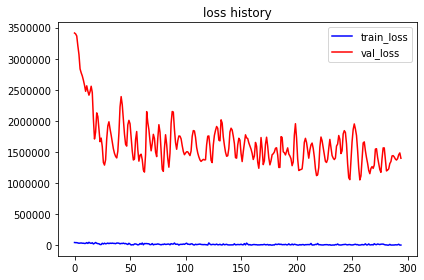

5/5 [==============================] - 0s 1ms/step


In [31]:
"""
Predict the korea spread of coronavirus with Dense modle
"""
k_pdm_reg = PandemicRegressor(window_size=WINDOW_SIZE, hidden_state=True, batch_size=8, n_feature=3, model_name='korea_lstm_pdm_reg', stateful=False)

hist = k_pdm_reg.fit(X_train=X_train,
                   y_train=y_train, 
                   validation_data=(X_test, y_test),
                   verbose=1,
                   epochs=3000)
show_train_hist(hist)
k_pdm_reg.load_best_weights()
loss_and_metrics = k_pdm_reg.evaluate(X_test=X_test, y_test=y_test)

In [32]:
print(f'MAE: {loss_and_metrics[1]}, MAPE: {loss_and_metrics[2]}')
print('===================================================== Prediction of X_test =====================================================')
y_hat = k_pdm_reg.predict(X_test)
y_dict = {'Confirmed': [x[0] for x in y_hat],
          'Deaths':[x[1] for x in y_hat],
          'Recovered':[x[2] for x in y_hat]}
y_df = pd.DataFrame(y_dict)
y_df

MAE: 631.6461181640625, MAPE: 27.661056518554688
===================================================== Prediction of X_test =====================================================


,Confirmed,Deaths,Recovered
0,1074.937866,12.905215,21.955570
1,1144.823608,13.771910,23.393053
2,1171.654907,14.128753,23.972858
3,1227.115967,14.857917,25.162382
4,1261.776855,15.294060,25.887896


In [33]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
n = 7
print(f'\n===================================================== Prediction of {n} days =====================================================')
prediction = k_pdm_reg.predict_n_days(n, X_test[-1], {'mean': _mean, 'std': _std})
prediction


===================================================== Prediction of 7 days =====================================================


,Confirmed,Deaths,Recovered
0,1261.777,15.294,25.888
1,1185.227,14.233,24.201
2,1178.901,14.163,24.072
3,1178.278,14.152,24.058
4,1180.037,14.154,24.076
5,1184.523,14.175,24.132
6,1194.366,14.280,24.317
